# <center> <B> CS517 Project </B></center>
## <center>GVF Snakes (Active contours) </center>
<center><img src="https://www.iitrpr.ac.in/sites/default/files/image.jpg" alt="logo" width="200"/></center>

### Submitted by: 
* ### Aneeket Mangal 2019CSB1071
* ### Sangram Jagadale 2019CSB1091


### 0. Project Description

This project is an python based implementation of the Gradient Vector Flow snake based on the paper [Snakes, Shapes, and Gradient Vector Flow by Xu & Prince](https://ieeexplore.ieee.org/document/661186).

This technique uses the original force balance equation, as the building point to design the snake (active contour):

$F_{int} + F_{ext}^{(p)} = 0$, where

$F_{int} = \alpha x''(s) - \beta x''''(s)$

$F_{ext} = v(x, y)$ 

Gradient Vector Flow (GVF) field is defined to be the vector field $v(x, y) = [u(x, y), v(x, y)]$ that minimizes the following energy equation.


$\epsilon = \iint \mu(u_{x}^{2} + u_{y}^{2} + v_{x}^{2} + v_{y}^{2}) + |\nabla f|^{2}|v-\nabla f|^{2} dxdy$




### 1. Package Imports

In [161]:
import matplotlib.pyplot as plt
import cv2
from tqdm.notebook import tqdm as tqdm
import skimage.filters as skimage_filter
import numpy as np

### 2. File input


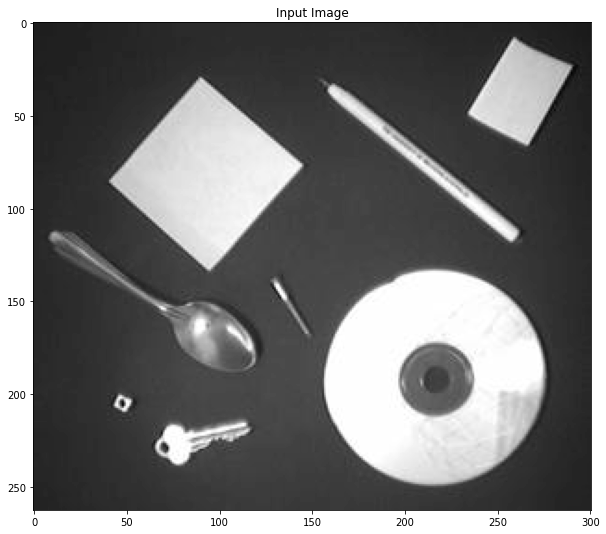

In [162]:
imgPath = "test_images/4.jpg" # file path 
# taking image as input, converting into grayscale
img = None
try:
    img = cv2.imread(imgPath, 0)
except:
    # in case file is not found
    print("Image path incorrect.")
    exit(0)

plt.figure(figsize=(10, 10))
plt.subplot(1, 1, 1)
plt.title("Input Image")
plt.imshow(img, cmap="gray")

### 3. Edge Map

To get the GVF field, the first step is to extract 
the edge map function $f(x, y)$ from the image $I(x, y)$. 

According to the paper, the edge map should follow given properties:
* The gradient of an edge map has vectors normal to the edges
* Large values of intensity near the edges.
* Places where $I(x, y)$ is constant, $\nabla f(x, y)$ is 0

A suitable edge map function, which has been considered is:

$f(x, y) = −|\nabla[G_{σ}(x , y)∗I(x , y)]|$

where $G_{σ}$(x , y) is a two dimension gaussian function with standard deviation $σ$.

* Gaussian filter has been used to remove noise from the image.
* Further, sobel filter has been applied for calculating gradient on the resultant image.


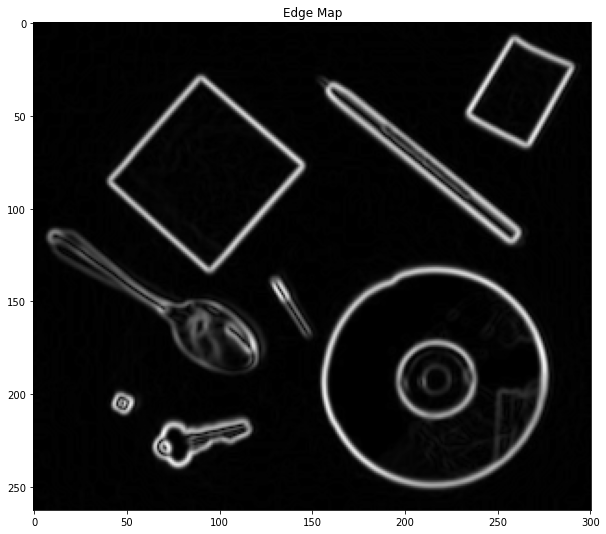

In [163]:
blurImg = cv2.GaussianBlur(img, (5, 5), 0)
gradX = cv2.Sobel(blurImg, cv2.CV_64F, 1, 0) # taking gradient in X direction
gradY = cv2.Sobel(blurImg, cv2.CV_64F, 0, 1) # taking gradient in Y direction
# calculating sqrt((gradX)**2 + (gradY)**2)
edgeMap = np.sqrt((gradX**2) + (gradY**2))
edgeMap = skimage_filter.sobel(blurImg)

plt.figure(figsize=(10, 10))
plt.subplot(1, 1, 1)
plt.title("Edge Map")
plt.imshow(edgeMap, cmap="gray")

### 4. Gradient field
Calculation of the gradient vectors of the edge map image

For horizontal direction:
$f_{x}(i, j) = (f(i, j+1) - f(i, j-1))/2$
for corner case:
* $f_{x}(i, 0) = f(i, 1) - f(i, 0)$
* $f_{x}(i, len-1) = f(i, len-1) - f(i, len-2)$

Similarly for gradient in vertical direction


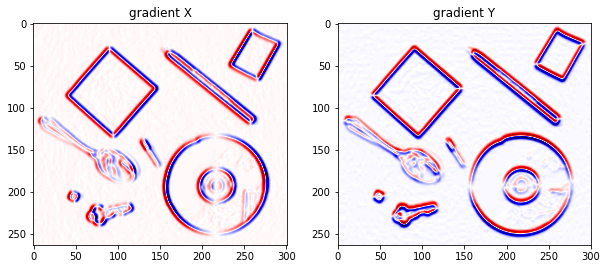

In [164]:
tempIm = edgeMap.copy()
tempIm = cv2.GaussianBlur(tempIm, (5, 5), 0)


gradientX = tempIm.copy()
gradientY = tempIm.copy()
for i in range(tempIm.shape[0]):
    for j in range(tempIm.shape[1]):
        if(j == 0):
            gradientX[i][j] = tempIm[i][j+1] - tempIm[i][j]
        elif(j == tempIm.shape[1]-1):
            gradientX[i][j] = tempIm[i][j] - tempIm[i][j-1]
        else:
            gradientX[i][j] = (tempIm[i][j+1] - tempIm[i][j-1])/2


for i in range(tempIm.shape[1]):
    for j in range(tempIm.shape[0]):
        if(j == 0):
            gradientY[j][i] = tempIm[j+1][i] - tempIm[j][i]
        elif(j == tempIm.shape[0]-1):
            gradientY[j][i] = tempIm[j][i] - tempIm[j-1][i]
        else:
            gradientY[j][i] = (tempIm[j+1][i] - tempIm[j-1][i])/2

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.title("gradient X")
plt.imshow(gradientX, cmap= "seismic")
plt.subplot(1, 2, 2)
plt.title("gradient Y")
plt.imshow(gradientY, cmap = "seismic")


### 5. Gradient Vector field

According to the paper, the iterative solution to the GVF, after few approximations can be written as:

$u_{i, j}^{n+1} = (1-b_{i, j}\Delta t)u_{i, j}^{n} + r(u_{i+1, j}^{n} + u_{i, j+1}^{n} + u_{i-1, j}^{n} + u_{i, j-1}^{n} - 4u_{i, j}^{n}) +  c_{i, j}^{1}\Delta t$

$v_{i, j}^{n+1} = (1-b_{i, j}\Delta t)v_{i, j}^{n} + r(v_{i+1, j}^{n} + v_{i, j+1}^{n} + v_{i-1, j}^{n} + v_{i, j-1}^{n} - 4v_{i, j}^{n}) +  c_{i, j}^{2}\Delta t$

These equations can be rewritten as (in terms of 2D matrix algebra(numpy)):

$u^{n+1} = (1-b*\Delta t)u^{n} + r*laplacian_{3x3}(u^{n}) + c_{1}\Delta t$

$v^{n+1} = (1-b*\Delta t)v^{n} + r*laplacian_{3x3}(v^{n}) + c_{2}\Delta t$

where, 

$r = μ\Delta t /\Delta x\Delta y$, the Courant–Friedrichs–Lewy step-size restriction

$b(x, y) = f_{x}(x, y)^{2} + f_{y}(x, y)^{2}$

$c^{1}(x, y) = b(x, y)f_{x}(x, y)$
    
$c^{2}(x, y) = b(x, y)f_{y}(x, y)$

$μ$ is a parameter that depends on the noise level of the image. It should be in directly proptional nature with the image noise level. If the noise is high, the value of $μ$, should be increased.

The paper suggests that "Provided that $b$, $c^{1}$ and $c^{2}$ are bounded, the first two equations are stable whenever the value of $r <= 0.25$".

We will calculate \Delta t using:

$\Delta t = \Delta x\Delta y/rμ$, the Courant–Friedrichs–Lewy step-size restriction


Number of iterations have been taken to be $\sqrt N$, as per the suggestion of the paper itself, where N is the area of the image $(h*w)$.


  0%|          | 0/281 [00:00<?, ?it/s]

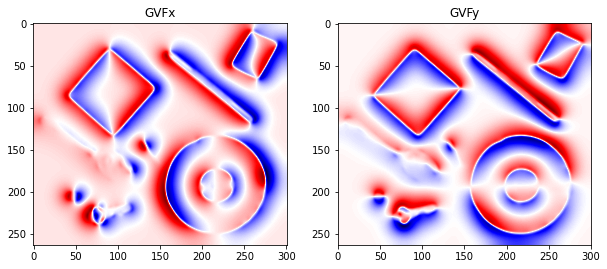

In [165]:
# parameters for GVF
# as defined in the above markdown
dx, dy = 1.0, 1.0
mu = 1
r = 0.25
b = np.square(gradientX) + np.square(gradientY)
c1, c2 = b*gradientX, b*gradientY
dt = dx*dy/(r*mu)
N = img.shape[0]*img.shape[1]
iter = int(np.sqrt(N)) 
iterations = list(range(iter))

# initializing u, v with the values of fx and fy
u, v = gradientX, gradientY

for i in tqdm(iterations):
    lapU = cv2.Laplacian(u, -1, 3) # laplacian with kernel size 3
    lapV = cv2.Laplacian(v, -1, 3)
    u = (1.0 - b*dt)*u + r*lapU + c1*dt
    v = (1.0 - b*dt)*v + r*lapV + c2*dt


gx, gy = u, v

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.title("GVFx")
plt.imshow(gx, cmap = "seismic")
plt.subplot(1, 2, 2)
plt.title("GVFy")
plt.imshow(gy, cmap = "seismic")



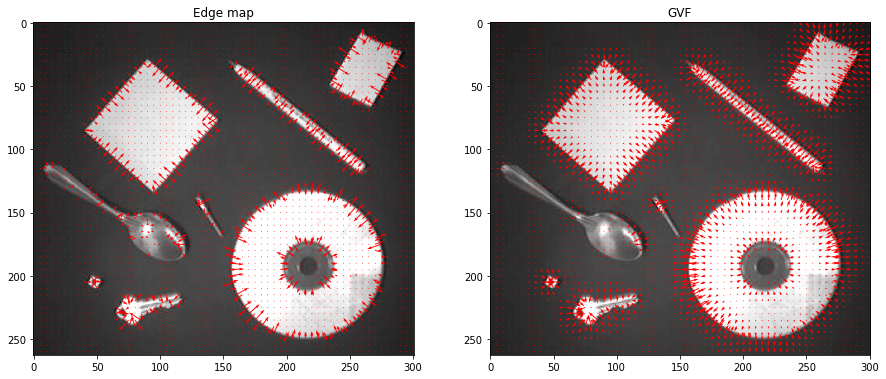

In [166]:
H, W = img.shape
Y, X = np.meshgrid(range(0, H, 5), range(0, W, 5))


plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.title("Edge map")
scale = np.sqrt(np.max(gradientX**2+gradientY**2))*25
plt.imshow(img, cmap='gray')
plt.quiver(X, Y, gradientX[Y, X], -gradientY[Y, X], scale=scale, color='red', headwidth = 3)


plt.subplot(1, 2, 2)
plt.title("GVF")
scale = np.sqrt(np.max(gx**2+gy**2))*25
plt.imshow(img, cmap='gray')
plt.quiver(X, Y, gx[Y, X], -gy[Y, X], scale=scale, color='red', headwidth = 3)

